In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None, 'display.max_rows', 100) 

from os import path
import pickle

import sys
sys.path.append('..')
import src.functions.my_functions as my_func

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics.scorer import make_scorer

from sklearn.metrics import f1_score, recall_score, precision_score, fbeta_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier, AdaBoostClassifier
from mlxtend.classifier import StackingClassifier

from sklearn.feature_selection import SelectFromModel, SelectKBest, SelectPercentile, RFECV, RFE, f_classif

from itertools import product

In [2]:
from imp import reload
reload(my_func)

<module 'src.functions.my_functions' from '..\\src\\functions\\my_functions.py'>

### Data Import

In [3]:
data = {}

ds = ['train', 'train_target', 'test', 'test_target']
d = ['..', 'data', 'processed']

for s in ds:    
    fn = 'loan_'+s+'.p'
    fp = path.join(*d, fn)

    with open(fp, 'rb') as file:
        data[s] = pickle.load(file)

In [4]:
data['train'].shape, data['train_target'].shape

((152218, 47), (152218, 2))

In [5]:
data['test'].shape, data['test_target'].shape

((38055, 47), (38055, 2))

### Data Prep

In [6]:
# Columns identified thus far as best for classification (during data prep, select K best)
num_attr = ['funded_amnt_q10', 'int_rate_delta', 'annual_inc_q10', 'dti', 'delinq_2yrs', 'inq_last_6mths',
            'open_acc', 'revol_bal_log', 'revol_util', 'total_acc', 'collections_12_mths_ex_med',
            'acc_now_delinq', 'rev_lim_sqrt', 'tot_cur_bal', 'tot_coll_amt', 'subgrade_p_value',
            'lti', 'rbti', 'tbti', 'cr_line_td_log', 'emp_length_val']

bin_attr = ['had_delinq', 'had_major_derog', 'had_record', 'verified', 'term_bin']

cat_attr = ['purpose', 'home_ownership']

In [7]:
num_prep = Pipeline([('custom', my_func.CustomNumAttributes()), # Create custom num attr
                     ('select', my_func.DataFrame_Selector(num_attr)), # Select num columns
                     ('sc', StandardScaler())]) # Scale data

bin_prep = Pipeline([('custom', my_func.CustomBinAttributes()), # Create custom bin attr
                     ('select', my_func.DataFrame_Selector(bin_attr))]) # Select binary columns

cat_prep = Pipeline([('encode', my_func.DataFrame_DummyEncoder(cat_attr))]) # Select & encode categrocial columns

feature_prep = FeatureUnion([('num', num_prep),
                             ('bin', bin_prep),
                             ('cat', cat_prep)])

In [8]:
X_train_full = feature_prep.fit_transform(data['train'])
X_test = feature_prep.transform(data['test'])

y_train_full = data['train_target']['default']
y_test = data['test_target']['default']

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

### Scoring

In [10]:
f2_score = make_scorer(fbeta_score, beta=2)

### Bagging/Pasting

##### Logistic Regression

In [17]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision',
         'specificity': make_scorer(my_func.binary_specificity)}

n = [10]
ms = np.arange(0.1,0.51,0.1)
mf = np.arange(0.1,0.91,0.1)

lr_best = LogisticRegression(class_weight='balanced',
                             C=1e-8)

param_grid = {'n_estimators': n,
              'max_samples': ms,
              'max_features': mf,
              'bootstrap': [True, False],
              'bootstrap_features': [True, False]}
              
              
bag_lr_gs = GridSearchCV(estimator=BaggingClassifier(lr_best),
                              param_grid = param_grid,
                              scoring=scoring,
                              cv=3,
                              refit=False,
                              n_jobs=4,
                              verbose=2)

my_func.run_time(reset=True)
bag_lr_gs.fit(X_train, y_train)
my_func.run_time()

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   22.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  5.5min


Time: 8min 45s 


[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  8.7min finished


In [18]:
my_func.gs_score_summary(bag_lr_gs);

--------------------
Best F2:
Params: {'bootstrap': False, 'bootstrap_features': False, 'max_features': 0.5, 'max_samples': 0.10000000000000001, 'n_estimators': 10}
F2 = 0.5594344980806638
Recall = 0.7494031184429233
Precision = 0.27779000973640877
Specificity = 0.5351119794907921
--------------------
Best Recall:
Params: {'bootstrap': False, 'bootstrap_features': True, 'max_features': 0.30000000000000004, 'max_samples': 0.10000000000000001, 'n_estimators': 10}
F2 = 0.557482587232081
Recall = 0.7656861372942044
Precision = 0.2674615387694146
Specificity = 0.4987692009146497
--------------------
Best Precision:
Params: {'bootstrap': True, 'bootstrap_features': False, 'max_features': 0.20000000000000001, 'max_samples': 0.5, 'n_estimators': 10}
F2 = 0.5500494241284213
Recall = 0.724253997289936
Precision = 0.2803979318137403
Specificity = 0.5562991781027611
--------------------
Best Specificity:
Params: {'bootstrap': False, 'bootstrap_features': True, 'max_features': 0.10000000000000001, 

At first glance, performance seems comparable to our best logistic regresion with RFE (whereas this used the full feature set with random feature selection). Let us see if we can further improve performance with different numbers of estimators and random states:

In [19]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision',
         'specificity': make_scorer(my_func.binary_specificity)}

n = [10,20,50,100]
rs = np.random.choice(1000,100,replace=False)

lr_bag_best = BaggingClassifier(base_estimator=LogisticRegression(class_weight='balanced', C=1e-8),
                                max_samples=0.1, max_features=0.5, bootstrap_features=False, bootstrap=False)

param_grid = {'n_estimators': n,
              'random_state': rs}
              
              
bag_lr_gs_rs = GridSearchCV(estimator=lr_bag_best,
                              param_grid = param_grid,
                              scoring=scoring,
                              cv=3,
                              refit=False,
                              n_jobs=4,
                              verbose=2)

my_func.run_time(reset=True)
bag_lr_gs_rs.fit(X_train, y_train)
my_func.run_time()

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   35.9s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  6.2min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed: 15.8min
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed: 48.1min


Time: 73min 57s 


[Parallel(n_jobs=4)]: Done 1200 out of 1200 | elapsed: 73.9min finished


In [20]:
my_func.gs_score_summary(bag_lr_gs_rs);

--------------------
Best F2:
Params: {'n_estimators': 10, 'random_state': 240}
F2 = 0.5620017680329654
Recall = 0.7611678369267089
Precision = 0.274618484809216
Specificity = 0.5202412543417095
--------------------
Best Recall:
Params: {'n_estimators': 10, 'random_state': 811}
F2 = 0.5594788310698856
Recall = 0.7656436830677532
Precision = 0.2693680107876574
Specificity = 0.5044246093782223
--------------------
Best Precision:
Params: {'n_estimators': 10, 'random_state': 691}
F2 = 0.5539260782651078
Recall = 0.7255754801240334
Precision = 0.28462847274855735
Specificity = 0.564792414055423
--------------------
Best Specificity:
Params: {'n_estimators': 10, 'random_state': 691}
F2 = 0.5539260782651078
Recall = 0.7255754801240334
Precision = 0.28462847274855735
Specificity = 0.564792414055423
--------------------


In [21]:
lr_bag = BaggingClassifier(base_estimator=LogisticRegression(class_weight='balanced', C=1e-8),
                           n_estimators=100, max_samples=0.1, max_features=0.5,
                           random_state=240)
lr_bag.fit(X_train, y_train)

BaggingClassifier(base_estimator=LogisticRegression(C=1e-08, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=0.5,
         max_samples=0.1, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=240, verbose=0, warm_start=False)

In [22]:
my_func.print_cvs(cross_val_score(lr_bag, X_train, y_train, cv=5, scoring='recall'), 'recall')

Mean recall score = 0.751 (+/- 0.003)


In [23]:
my_func.classifier_summary(y_train, lr_bag.predict(X_train));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               52190               46124
Actual Positive                5866               17594
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.558334
Recall           0.749957
Precision (pos)  0.276123
Precision (neg)  0.898960
Specificity      0.530850


In [25]:
my_func.classifier_summary(y_val, lr_bag.predict(X_val));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               13083               11547
Actual Positive                1454                4360
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.556648
Recall           0.749914
Precision (pos)  0.274093
Precision (neg)  0.899979
Specificity      0.531181


Our bagging classifier with logisitic regression appears to perform just slightly better than our basic logistic regression model. Perhaps reducing the feature set via RFE can yield better results:

In [16]:
rfe = RFE(estimator=LogisticRegression(class_weight='balanced'), n_features_to_select=28)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_val_rfe = rfe.transform(X_val)

In [28]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision',
         'specificity': make_scorer(my_func.binary_specificity)}

n = [10]
ms = np.arange(0.1,.51,0.1)
mf = np.arange(0.1,1.01,0.1)

lr_best = LogisticRegression(class_weight='balanced',
                             C=1e-8)

param_grid = {'n_estimators': n,
              'max_samples': ms,
              'max_features': mf,
              'bootstrap': [True, False],
              'bootstrap_features': [True, False]}
              
              
bag_lr_gs = GridSearchCV(estimator=BaggingClassifier(lr_best),
                              param_grid = param_grid,
                              scoring=scoring,
                              cv=3,
                              refit=False,
                              n_jobs=4,
                              verbose=2)

my_func.run_time(reset=True)
bag_lr_gs.fit(X_train_rfe, y_train)
my_func.run_time()

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   19.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  4.2min


Time: 7min 30s 


[Parallel(n_jobs=4)]: Done 600 out of 600 | elapsed:  7.5min finished


In [29]:
my_func.gs_score_summary(bag_lr_gs);

--------------------
Best F2:
Params: {'bootstrap': True, 'bootstrap_features': True, 'max_features': 0.80000000000000004, 'max_samples': 0.20000000000000001, 'n_estimators': 10}
F2 = 0.5631514820400069
Recall = 0.7639812516725777
Precision = 0.27451060763794466
Specificity = 0.5181866302909446
--------------------
Best Recall:
Params: {'bootstrap': False, 'bootstrap_features': True, 'max_features': 0.30000000000000004, 'max_samples': 0.5, 'n_estimators': 10}
F2 = 0.5610257708124288
Recall = 0.7652600702563471
Precision = 0.2714166762710959
Specificity = 0.5096629432461715
--------------------
Best Precision:
Params: {'bootstrap': True, 'bootstrap_features': False, 'max_features': 0.5, 'max_samples': 0.40000000000000002, 'n_estimators': 10}
F2 = 0.5573478328519754
Recall = 0.7400256930609413
Precision = 0.2806180777273003
Specificity = 0.5469719929706734
--------------------
Best Specificity:
Params: {'bootstrap': True, 'bootstrap_features': False, 'max_features': 0.10000000000000001, 

In [21]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision',
         'specificity': make_scorer(my_func.binary_specificity)}

n = [10]
rs = np.random.choice(1000,100,replace=False)

lr_bag_best = BaggingClassifier(base_estimator=LogisticRegression(class_weight='balanced', C=1e-8),
                                max_samples=0.2, max_features=0.8, bootstrap_features=True, bootstrap=True)

param_grid = {'n_estimators': n,
              'random_state': rs}
              
              
bag_lr_gs_rs = GridSearchCV(estimator=lr_bag_best,
                              param_grid = param_grid,
                              scoring=scoring,
                              cv=3,
                              refit=False,
                              n_jobs=4,
                              verbose=2)

my_func.run_time(reset=True)
bag_lr_gs_rs.fit(X_train_rfe, y_train)
my_func.run_time()

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   38.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  2.6min


Time: 4min 58s 


[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  5.0min finished


In [22]:
my_func.gs_score_summary(bag_lr_gs_rs);

--------------------
Best F2:
Params: {'n_estimators': 10, 'random_state': 912}
F2 = 0.5643143143418878
Recall = 0.7645353692179848
Precision = 0.27561135941914283
Specificity = 0.5204752235569098
--------------------
Best Recall:
Params: {'n_estimators': 10, 'random_state': 981}
F2 = 0.5640853358115085
Recall = 0.7709718449551656
Precision = 0.27206298534193146
Specificity = 0.5077608518621809
--------------------
Best Precision:
Params: {'n_estimators': 10, 'random_state': 600}
F2 = 0.5544857778811442
Recall = 0.7259164811910807
Precision = 0.2851517186899203
Specificity = 0.5657180147649826
--------------------
Best Specificity:
Params: {'n_estimators': 10, 'random_state': 600}
F2 = 0.5544857778811442
Recall = 0.7259164811910807
Precision = 0.2851517186899203
Specificity = 0.5657180147649826
--------------------


In [23]:
lr_bag_best = BaggingClassifier(base_estimator=LogisticRegression(class_weight='balanced', C=1e-8),
                                max_samples=0.2, max_features=0.8, bootstrap_features=True, bootstrap=True,
                                n_estimators=10, random_state=912)

lr_bag_best.fit(X_train_rfe, y_train)

BaggingClassifier(base_estimator=LogisticRegression(C=1e-08, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=True, max_features=0.8,
         max_samples=0.2, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=912, verbose=0, warm_start=False)

In [33]:
my_func.print_cvs(cross_val_score(lr_bag_best, X_train, y_train, cv=5, scoring='recall'))

Mean CV score = 0.760 (+/- 0.006)


In [24]:
my_func.classifier_summary(y_train, lr_bag_best.predict(X_train_rfe));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               51714               46600
Actual Positive                5599               17861
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.564147
Recall           0.761338
Precision (pos)  0.277082
Precision (neg)  0.902308
Specificity      0.526009


In [25]:
my_func.classifier_summary(y_val, lr_bag_best.predict(X_val_rfe));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               12977               11653
Actual Positive                1382                4432
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.563280
Recall           0.762298
Precision (pos)  0.275536
Precision (neg)  0.903754
Specificity      0.526878


This bagging classifier is able to achieve slightly better results in recall/F2 than the individual logistic regression model which scored in the 0.74 recall range.

##### Linear SVC

In [16]:
svc_rfe = RFE(estimator=LinearSVC(class_weight='balanced', dual=False), n_features_to_select=31)

my_func.run_time(reset=True)
svc_rfe.fit(X_train, y_train)
my_func.run_time()

Time: 4min 58s 


In [17]:
X_train_rfe = svc_rfe.transform(X_train)
X_val_rfe = svc_rfe.transform(X_val)

In [43]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision',
         'specificity': make_scorer(my_func.binary_specificity)}

n = [10]
ms = np.arange(0.1,0.51,0.1)
mf = np.arange(0.1,0.91,0.1)

lsvc_best = LinearSVC(class_weight='balanced',
                             dual=False,
                             C=1e-7)

param_grid = {'n_estimators': n,
              'max_samples': ms,
              'max_features': mf,
              'bootstrap': [True, False],
              'bootstrap_features': [True, False]}
              
              
bag_lsvc_gs = GridSearchCV(estimator=BaggingClassifier(lsvc_best),
                              param_grid = param_grid,
                              scoring=scoring,
                              cv=3,
                              refit=False,
                              n_jobs=4,
                              verbose=2)

my_func.run_time(reset=True)
bag_lsvc_gs.fit(X_train_rfe, y_train)
my_func.run_time()

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  5.9min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed: 12.9min


Time: 19min 21s 


[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed: 19.3min finished


In [44]:
my_func.gs_score_summary(bag_lsvc_gs);

--------------------
Best F2:
Params: {'bootstrap': False, 'bootstrap_features': False, 'max_features': 0.80000000000000004, 'max_samples': 0.20000000000000001, 'n_estimators': 10}
F2 = 0.5592059894837366
Recall = 0.7416453509933731
Precision = 0.28186230223931485
Specificity = 0.5490977904537727
--------------------
Best Recall:
Params: {'bootstrap': False, 'bootstrap_features': False, 'max_features': 0.90000000000000002, 'max_samples': 0.40000000000000002, 'n_estimators': 10}
F2 = 0.5590838657712465
Recall = 0.7446291213562906
Precision = 0.2800350213979244
Specificity = 0.5430864350629773
--------------------
Best Precision:
Params: {'bootstrap': False, 'bootstrap_features': False, 'max_features': 0.30000000000000004, 'max_samples': 0.20000000000000001, 'n_estimators': 10}
F2 = 0.5407294410959187
Recall = 0.6916881759119666
Precision = 0.2891902118148557
Specificity = 0.5934760763915768
--------------------
Best Specificity:
Params: {'bootstrap': True, 'bootstrap_features': False, '

In [18]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision',
         'specificity': make_scorer(my_func.binary_specificity)}

n = [10]
rs = np.random.choice(1000,100,replace=False)

lsvc_best = LinearSVC(class_weight='balanced', dual=False, C=1e-7)

lsvc_bag_best = BaggingClassifier(base_estimator=lsvc_best,
                                max_samples=0.2, max_features=0.8, bootstrap_features=False, bootstrap=False)

param_grid = {'n_estimators': n,
              'random_state': rs}
              
              
bag_lsvc_gs_rs = GridSearchCV(estimator=lsvc_bag_best,
                              param_grid = param_grid,
                              scoring=scoring,
                              cv=3,
                              refit=False,
                              n_jobs=4,
                              verbose=2)

my_func.run_time(reset=True)
bag_lsvc_gs_rs.fit(X_train_rfe, y_train)
my_func.run_time()

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  6.1min


Time: 11min 50s 


[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed: 11.8min finished


In [19]:
my_func.gs_score_summary(bag_lsvc_gs_rs);

--------------------
Best F2:
Params: {'n_estimators': 10, 'random_state': 521}
F2 = 0.5599233896500295
Recall = 0.7497015991259982
Precision = 0.27821638078034466
Specificity = 0.5358748535994515
--------------------
Best Recall:
Params: {'n_estimators': 10, 'random_state': 521}
F2 = 0.5599233896500295
Recall = 0.7497015991259982
Precision = 0.27821638078034466
Specificity = 0.5358748535994515
--------------------
Best Precision:
Params: {'n_estimators': 10, 'random_state': 892}
F2 = 0.5554190019646637
Recall = 0.7275788632306451
Precision = 0.28534587052767163
Specificity = 0.565168746758098
--------------------
Best Specificity:
Params: {'n_estimators': 10, 'random_state': 797}
F2 = 0.5482968582517055
Recall = 0.7166666789180595
Precision = 0.2826672142401392
Specificity = 0.5660129816558485
--------------------


In [20]:
lsvc_best = LinearSVC(class_weight='balanced', dual=False, C=1e-7)
lsvc_bag = BaggingClassifier(base_estimator=lsvc_best, n_estimators=10, max_samples=0.2, max_features=0.8,
                             bootstrap_features=False, bootstrap=False,
                             random_state=521)

lsvc_bag.fit(X_train_rfe, y_train)

BaggingClassifier(base_estimator=LinearSVC(C=1e-07, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
         bootstrap=False, bootstrap_features=False, max_features=0.8,
         max_samples=0.2, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=521, verbose=0, warm_start=False)

In [21]:
my_func.print_cvs(cross_val_score(lsvc_bag, X_train_rfe, y_train, cv=5, scoring='recall'))

Mean CV score = 0.749 (+/- 0.003)


In [22]:
my_func.classifier_summary(y_train, lsvc_bag.predict(X_train_rfe));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               52897               45417
Actual Positive                5893               17567
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.560086
Recall           0.748806
Precision (pos)  0.278912
Precision (neg)  0.899762
Specificity      0.538041


In [23]:
my_func.classifier_summary(y_val, lsvc_bag.predict(X_val_rfe));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               13314               11316
Actual Positive                1460                4354
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.559266
Recall           0.748882
Precision (pos)  0.277856
Precision (neg)  0.901178
Specificity      0.540560


This baggig classifier shows an improvement in recall on the magnitude of 0.001 over the singular linear SVC model. This slight increase, however, does not seem to have come at the expense of specificity or precision which also see similar improvement. Consequently, whilst these improvements are very minimal this bagging classifier does provide a slightly more robust solution.

##### Decision Tree Classifier

Bagging our decision tree classifier is essentially constructing a rough random forest model, however we gain the added ability to reduce the number of samples used in each tree. Using what we had seen in previous grid searches for random forest as the best performing parameters and value ranges, we will repeat said process with a bagging classifier of 10 random forest classifiers. Note, however, that the process of feature selection has been moved from the random forest classifier up to the bagging classifier.

In [28]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision',
         'specificity': make_scorer(my_func.binary_specificity)}

n = [10, 15, 20]
ms = np.arange(0.2,0.51,0.1)
mf = np.arange(0.2,0.91,0.1)
md = np.arange(1,11,1)

dtc_bag = BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced'))

param_grid = {'base_estimator__max_depth': md,
              'n_estimators': n,
              'max_samples': ms,
              'max_features': mf,
              'bootstrap_features': [True, False]}
              
              
dtc_bag_gs = GridSearchCV(estimator=dtc_bag,
                              param_grid = param_grid,
                              scoring=scoring,
                              cv=3,
                              refit=False,
                              n_jobs=4,
                              verbose=2)

my_func.run_time(reset=True)
dtc_bag_gs.fit(X_train, y_train)
my_func.run_time()

Fitting 3 folds for each of 640 candidates, totalling 1920 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   22.9s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  4.5min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  8.5min
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed: 14.1min
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed: 21.8min


Time: 30min 49s 


[Parallel(n_jobs=4)]: Done 1920 out of 1920 | elapsed: 30.8min finished


In [29]:
my_func.gs_score_summary(dtc_bag_gs);

--------------------
Best F2:
Params: {'base_estimator__max_depth': 5, 'bootstrap_features': True, 'max_features': 0.90000000000000013, 'max_samples': 0.40000000000000008, 'n_estimators': 10}
F2 = 0.53678209149419
Recall = 0.663938590572608
Precision = 0.3039521928054217
Specificity = 0.6371829059552738
--------------------
Best Recall:
Params: {'base_estimator__max_depth': 1, 'bootstrap_features': False, 'max_features': 0.90000000000000013, 'max_samples': 0.40000000000000008, 'n_estimators': 10}
F2 = 0.5345618793721649
Recall = 0.7043904787859713
Precision = 0.2723405391468542
Specificity = 0.5503896015056183
--------------------
Best Precision:
Params: {'base_estimator__max_depth': 10, 'bootstrap_features': False, 'max_features': 0.90000000000000013, 'max_samples': 0.20000000000000001, 'n_estimators': 10}
F2 = 0.4560456917741673
Recall = 0.504092054809343
Precision = 0.33032007452125606
Specificity = 0.7561283226879555
--------------------
Best Specificity:
Params: {'base_estimator__

In [60]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision',
         'specificity': make_scorer(my_func.binary_specificity)}

n = [10,20,50,100]
rs = np.random.choice(1000,100,replace=False)

dtc_best = DecisionTreeClassifier(class_weight='balanced', max_depth=1)

dtc_bag_best = BaggingClassifier(base_estimator=dtc_best,
                                 bootstrap=False, bootstrap_features=False, 
                                 max_features=0.7, max_samples=0.2)

param_grid = {'n_estimators': n,
              'random_state': rs}
              
              
bag_dtc_gs_rs = GridSearchCV(estimator=dtc_bag_best,
                              param_grid = param_grid,
                              scoring=scoring,
                              cv=3,
                              refit=False,
                              n_jobs=4,
                              verbose=2)

my_func.run_time(reset=True)
bag_dtc_gs_rs.fit(X_train, y_train)
my_func.run_time()

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   36.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  6.3min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed: 16.0min
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed: 49.0min


Time: 75min 29s 


[Parallel(n_jobs=4)]: Done 1200 out of 1200 | elapsed: 75.5min finished


In [61]:
my_func.gs_score_summary(bag_dtc_gs_rs);

--------------------
Best F2:
Params: {'n_estimators': 10, 'random_state': 321}
F2 = 0.5388335922760672
Recall = 0.7209717577952568
Precision = 0.2680661195492892
Specificity = 0.5302500091793592
--------------------
Best Recall:
Params: {'n_estimators': 10, 'random_state': 321}
F2 = 0.5388335922760672
Recall = 0.7209717577952568
Precision = 0.2680661195492892
Specificity = 0.5302500091793592
--------------------
Best Precision:
Params: {'n_estimators': 20, 'random_state': 90}
F2 = 0.45287796804654684
Recall = 0.5168797008856748
Precision = 0.3029689797666358
Specificity = 0.7161950304089691
--------------------
Best Specificity:
Params: {'n_estimators': 20, 'random_state': 90}
F2 = 0.45287796804654684
Recall = 0.5168797008856748
Precision = 0.3029689797666358
Specificity = 0.7161950304089691
--------------------


In [66]:
dtc_bag_best = BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=1),
                            bootstrap=False, bootstrap_features=False, 
                            max_features=0.7, max_samples=0.2,
                            random_state=321)

dtc_bag_best.fit(X_train, y_train);

In [67]:
my_func.print_cvs(cross_val_score(dtc_bag_best, X_train, y_train, cv=5, scoring=f2_score), 'f2')
my_func.print_cvs(cross_val_score(dtc_bag_best, X_train, y_train, cv=5, scoring='recall'), 'recall')

Mean f2 score = 0.526 (+/- 0.007)
Mean recall score = 0.679 (+/- 0.020)


In [68]:
my_func.classifier_summary(y_train, dtc_bag_best.predict(X_train));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               58462               39852
Actual Positive                7996               15464
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.518383
Recall           0.659165
Precision (pos)  0.279557
Precision (neg)  0.879683
Specificity      0.594646


In [69]:
my_func.classifier_summary(y_val, dtc_bag_best.predict(X_val));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               14564               10066
Actual Positive                2017                3797
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.511463
Recall           0.653079
Precision (pos)  0.273895
Precision (neg)  0.878355
Specificity      0.591311


Unfortunately this baggig classifier performs singificantly worse than our singular optimized decision tree.

##### Random Forest

Rather surprisingly, our random forest classifier model fared signficantly worse than our individual decision tree. Perhaps bagging a number of random forest classifiers which are fit on varying subsamples can yield improvements.

In [15]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision',
         'specificity': make_scorer(my_func.binary_specificity)}

n = [10]
ms = np.arange(0.1,0.51,0.1)
mf = np.arange(0.1,0.51,0.1)
md = np.arange(1,6,1)
msl = np.arange(0.05,0.11,0.01)

rfc_bag = BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced'))

param_grid = {'base_estimator__max_depth': md,
              'base_estimator__min_samples_leaf': msl,
              'n_estimators': n,
              'max_samples': ms,
              'max_features': mf}
              
              
rfc_bag_gs = GridSearchCV(estimator=rfc_bag,
                              param_grid = param_grid,
                              scoring=scoring,
                              cv=3,
                              refit=False,
                              n_jobs=4,
                              verbose=2)

my_func.run_time(reset=True)
rfc_bag_gs.fit(X_train, y_train)
my_func.run_time()

Fitting 3 folds for each of 750 candidates, totalling 2250 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   54.7s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  7.7min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed: 13.5min
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed: 21.1min
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed: 30.3min
[Parallel(n_jobs=4)]: Done 1977 tasks      | elapsed: 41.2min


Time: 47min 5s 


[Parallel(n_jobs=4)]: Done 2250 out of 2250 | elapsed: 47.1min finished


In [17]:
rfc_gs_summary = my_func.gs_score_summary(rfc_bag_gs);

--------------------
Best F2:
Params: {'base_estimator__max_depth': 1, 'base_estimator__min_samples_leaf': 0.050000000000000003, 'max_features': 0.10000000000000001, 'max_samples': 0.10000000000000001, 'n_estimators': 10}
F2 = 0.5440277532818429
Recall = 1.0
Precision = 0.19265196183093272
Specificity = 0.0
--------------------
Best Recall:
Params: {'base_estimator__max_depth': 1, 'base_estimator__min_samples_leaf': 0.050000000000000003, 'max_features': 0.10000000000000001, 'max_samples': 0.10000000000000001, 'n_estimators': 10}
F2 = 0.5440277532818429
Recall = 1.0
Precision = 0.19265196183093272
Specificity = 0.0
--------------------
Best Precision:
Params: {'base_estimator__max_depth': 5, 'base_estimator__min_samples_leaf': 0.050000000000000003, 'max_features': 0.5, 'max_samples': 0.30000000000000004, 'n_estimators': 10}
F2 = 0.5100696036621141
Recall = 0.6218243738757685
Precision = 0.29682392905454735
Specificity = 0.6484834380012143
--------------------
Best Specificity:
Params: {

In [18]:
rfc_gs_summary[rfc_gs_summary['specificity'] > 0.5].sort_values('F2', ascending=False)[:10]

,F2,precision,recall,specificity,base_estimator__max_depth,base_estimator__min_samples_leaf,max_features,max_samples,n_estimators
7,0.531220,0.284090,0.679326,0.591208,1,0.05,0.2,0.3,10
624,0.530213,0.286292,0.673785,0.599162,5,0.05,0.5,0.5,10
49,0.530193,0.286227,0.673785,0.599030,1,0.06,0.5,0.5,10
619,0.529682,0.291104,0.666624,0.612425,5,0.05,0.4,0.5,10
439,0.529238,0.283078,0.676257,0.591289,3,0.10,0.3,0.5,10
322,0.529226,0.286958,0.670887,0.602142,3,0.05,0.5,0.3,10
512,0.529041,0.282727,0.676556,0.590231,4,0.07,0.3,0.3,10
468,0.528292,0.289226,0.666113,0.609272,4,0.05,0.4,0.4,10
604,0.528053,0.287137,0.668286,0.604034,5,0.05,0.1,0.5,10
369,0.527554,0.287073,0.667349,0.604471,3,0.07,0.4,0.5,10


We will proceed with the 2nd highest model with a max depth of 5 to avoid overlap and redundancy with our previous decision tree bagging classifier.

Repeating our grid search on the random state to ensure reporucible results:

In [20]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision',
         'specificity': make_scorer(my_func.binary_specificity)}

n = [10]
rs = np.random.choice(1000,100,replace=False)

rfc_bag_test = BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=0.05),
                                 max_features=0.2, max_samples=0.3)

param_grid = {'n_estimators': n,
              'random_state': rs}
              
              
rfc_bag_gs_rs = GridSearchCV(estimator=rfc_bag_test,
                              param_grid = param_grid,
                              scoring=scoring,
                              cv=3,
                              refit=False,
                              n_jobs=4,
                              verbose=2)

my_func.run_time(reset=True)
rfc_bag_gs_rs.fit(X_train, y_train)
my_func.run_time()

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   46.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  3.2min


Time: 6min 8s 


[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  6.1min finished


In [21]:
rfc_gs_rs_summary = my_func.gs_score_summary(rfc_bag_gs_rs)

--------------------
Best F2:
Params: {'n_estimators': 10, 'random_state': 748}
F2 = 0.5317842051103716
Recall = 0.6888743600204933
Precision = 0.27863735765936076
Specificity = 0.5739466750648292
--------------------
Best Recall:
Params: {'n_estimators': 10, 'random_state': 653}
F2 = 0.5282411968708435
Recall = 0.6909633751122629
Precision = 0.2721392481442231
Specificity = 0.558882784002206
--------------------
Best Precision:
Params: {'n_estimators': 10, 'random_state': 340}
F2 = 0.5021351468833133
Recall = 0.6067347327448268
Precision = 0.2973531546797534
Specificity = 0.6578004925213042
--------------------
Best Specificity:
Params: {'n_estimators': 10, 'random_state': 577}
F2 = 0.4716140517934157
Recall = 0.553751240663546
Precision = 0.2966131389379102
Specificity = 0.6863417545965096
--------------------


In [23]:
rfc_bag_best = BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=0.05),
                                 max_features=0.2, max_samples=0.3,
                                 n_estimators=10, random_state=748)

rfc_bag_best.fit(X_train, y_train);

In [24]:
my_func.print_cvs(cross_val_score(rfc_bag_best, X_train, y_train, cv=5, scoring=f2_score), 'f2')
my_func.print_cvs(cross_val_score(rfc_bag_best, X_train, y_train, cv=5, scoring='recall'), 'recall')

Mean f2 score = 0.526 (+/- 0.013)
Mean recall score = 0.674 (+/- 0.033)


In [25]:
my_func.classifier_summary(y_train, rfc_bag_best.predict(X_train));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               53822               44492
Actual Positive                6685               16775
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.540756
Recall           0.715047
Precision (pos)  0.273802
Precision (neg)  0.889517
Specificity      0.547450


In [26]:
my_func.classifier_summary(y_val, rfc_bag_best.predict(X_val));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               13545               11085
Actual Positive                1707                4107
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.534098
Recall           0.706398
Precision (pos)  0.270340
Precision (neg)  0.888080
Specificity      0.549939


While these results are not awful, we are unfortunately unable to exceed the performance of our singular random forest classifier. It is very possible that we simply have not explored the optimal hyperparameter combinations for both the bagging classifier and the base random forest estimators. The number of estimators has been kept at 10 throughout our optimization, and the random forest parameters tuning was constrained to be somewhat basic, but exploring all of these possible combination in-depth would come at an unreasonable time cost considering this reduced set of tuning already took 47 minutes to complete.

##### Gaussian Naive Bayes

Gaussian Naive Bayes has not been explored yet, as it was established during the MVP analysis that this model performed very poorly in comporison with other benchmarks and models. However, it is possible that in conjunction with bagging and smaller sample sizes that these results reach more acceptable levels. Whilst it is unlikely it will ever be at a level to perform reliable individually, perhaps it can be incorporated in an ensemble with other models to yield optimal performance.

First we will take a look at the basic Gaussian NB model performance:

In [28]:
gnb_basic = GaussianNB()
gnb_basic.fit(X_train, y_train);

In [34]:
my_func.print_cvs(cross_val_score(gnb_basic, X_train, y_train, cv=5, scoring=f2_score), 'f2')
my_func.print_cvs(cross_val_score(gnb_basic, X_train, y_train, cv=5, scoring='recall'), 'recall')

Mean f2 score = 0.410 (+/- 0.030)
Mean recall score = 0.438 (+/- 0.046)


In [36]:
my_func.classifier_summary(y_train, gnb_basic.predict(X_train));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               78143               20171
Actual Positive               13335               10125
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.407819
Recall           0.431586
Precision (pos)  0.334203
Precision (neg)  0.854227
Specificity      0.794831


In [37]:
my_func.classifier_summary(y_val, gnb_basic.predict(X_val));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               19676                4954
Actual Positive                3362                2452
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.399843
Recall           0.421741
Precision (pos)  0.331083
Precision (neg)  0.854067
Specificity      0.798863


Next we will see if there is any immediate potential in reducing the number of features via Select K Best:

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Done 3 tasks | elapsed: 3.04s 
Done 33 tasks | elapsed: 32.18s 
Done 63 tasks | elapsed: 1min 3s 
Done 93 tasks | elapsed: 1min 33s 
Done 120 out of 120 | elapsed: 2min 1s  finished


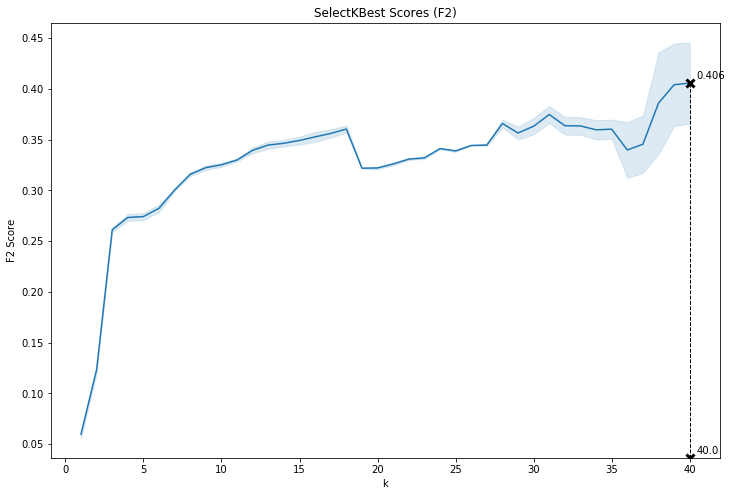

In [34]:
gnb_skb_results = my_func.plot_skb(GaussianNB(), X_train, y_train, k_range=np.arange(1,41,1), scoring='f2', n_jobs=3, verbose=9)

Does not seem to be much benefit achievable through SelectKBest feature selection. We will proceed with the grid search using a bagging classifier:

In [17]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision': 'precision',
         'specificity': make_scorer(my_func.binary_specificity)}

gnb_test = GaussianNB()

gnb_bag_test = BaggingClassifier(base_estimator=gnb_test)

n = [10,20,50,100]
ms = np.arange(0.1,0.51,0.1)
mf = np.arange(0.1,.51,0.1)

param_grid = {'n_estimators': n,
              'max_samples': ms,
              'max_features': mf}
              
gnb_bag_gs = GridSearchCV(estimator=gnb_bag_test,
                              param_grid = param_grid,
                              scoring=scoring,
                              cv=3,
                              refit=False,
                              n_jobs=4,
                              verbose=2)

my_func.run_time(reset=True)
gnb_bag_gs.fit(X_train, y_train)
my_func.run_time()

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  8.3min


Time: 25min 40s 


[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed: 25.7min finished


In [18]:
gnb_gs_summary = my_func.gs_score_summary(gnb_bag_gs);

--------------------
Best F2:
Params: {'max_features': 0.5, 'max_samples': 0.20000000000000001, 'n_estimators': 50}
F2 = 0.5510003394562453
Recall = 0.9574171076713027
Precision = 0.20536898343726204
Specificity = 0.10795019583451829
--------------------
Best Recall:
Params: {'max_features': 0.30000000000000004, 'max_samples': 0.20000000000000001, 'n_estimators': 20}
F2 = 0.546014864433759
Recall = 0.9874254893041771
Precision = 0.19587196876445004
Specificity = 0.032375909867361975
--------------------
Best Precision:
Params: {'max_features': 0.10000000000000001, 'max_samples': 0.20000000000000001, 'n_estimators': 50}
F2 = 0.00010656139573189167
Recall = 8.525184194090289e-05
Precision = 0.6666694039778607
Specificity = 1.0
--------------------
Best Specificity:
Params: {'max_features': 0.10000000000000001, 'max_samples': 0.10000000000000001, 'n_estimators': 100}
F2 = 0.0
Recall = 0.0
Precision = 0.0
Specificity = 1.0
--------------------


The best results for F2 and recall unfortunately come at an unacceptable cost to precision and specificity. We will explore the grid search results with a specificity over 0.5:

In [19]:
gnb_gs_summary[gnb_gs_summary['specificity'] > 0.5].sort_values('F2', ascending=False)[:10]

,F2,precision,recall,specificity,max_features,max_samples,n_estimators
46,0.504645,0.287719,0.641391,0.606048,0.3,0.2,50
42,0.500690,0.288401,0.638748,0.605957,0.3,0.1,50
43,0.487782,0.297715,0.603623,0.639746,0.3,0.1,100
41,0.487508,0.277554,0.667777,0.512013,0.3,0.1,20
74,0.485914,0.302557,0.572975,0.684704,0.4,0.4,50
89,0.475716,0.306993,0.551876,0.702311,0.5,0.3,20
69,0.450914,0.296524,0.574598,0.621998,0.4,0.3,20
71,0.449124,0.307544,0.544034,0.683514,0.4,0.3,100
49,0.446966,0.297594,0.596462,0.590292,0.3,0.3,20
75,0.431746,0.302884,0.541516,0.650680,0.4,0.4,100


Since we are working with random selections of features and samples, we will also try to contrain our random state for reproducible results:

In [11]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision': 'precision',
         'specificity': make_scorer(my_func.binary_specificity)}

gnb_bag_test = BaggingClassifier(base_estimator=GaussianNB(),
                             max_features=0.3, max_samples=0.2,
                             n_estimators=50)

rs = np.random.choice(1000,100,replace=False)

param_grid = {'random_state': rs}
              
gnb_bag_gs = GridSearchCV(estimator=gnb_bag_test,
                              param_grid = param_grid,
                              scoring=scoring,
                              cv=3,
                              refit=False,
                              n_jobs=4,
                              verbose=2)

my_func.run_time(reset=True)
gnb_bag_gs.fit(X_train, y_train)
my_func.run_time()

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 14.5min


Time: 27min 50s 


[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed: 27.8min finished


In [12]:
my_func.gs_score_summary(gnb_bag_gs);

--------------------
Best F2:
Params: {'random_state': 475}
F2 = 0.5575548512891193
Recall = 0.8846553835819378
Precision = 0.228668375884531
Specificity = 0.27144692409855553
--------------------
Best Recall:
Params: {'random_state': 684}
F2 = 0.5517213336235701
Recall = 0.9456950607886808
Precision = 0.20863756225424387
Specificity = 0.1330127407209551
--------------------
Best Precision:
Params: {'random_state': 301}
F2 = 0.15585431243158449
Recall = 0.13699969739759837
Precision = 0.4026915309085073
Specificity = 0.9500580389871074
--------------------
Best Specificity:
Params: {'random_state': 301}
F2 = 0.15585431243158449
Recall = 0.13699969739759837
Precision = 0.4026915309085073
Specificity = 0.9500580389871074
--------------------


In [13]:
gnb_bag_gs_summary = my_func.gs_score_summary(gnb_bag_gs);

--------------------
Best F2:
Params: {'random_state': 475}
F2 = 0.5575548512891193
Recall = 0.8846553835819378
Precision = 0.228668375884531
Specificity = 0.27144692409855553
--------------------
Best Recall:
Params: {'random_state': 684}
F2 = 0.5517213336235701
Recall = 0.9456950607886808
Precision = 0.20863756225424387
Specificity = 0.1330127407209551
--------------------
Best Precision:
Params: {'random_state': 301}
F2 = 0.15585431243158449
Recall = 0.13699969739759837
Precision = 0.4026915309085073
Specificity = 0.9500580389871074
--------------------
Best Specificity:
Params: {'random_state': 301}
F2 = 0.15585431243158449
Recall = 0.13699969739759837
Precision = 0.4026915309085073
Specificity = 0.9500580389871074
--------------------


In [14]:
gnb_bag_gs_summary[gnb_bag_gs_summary['specificity'] > 0.5].sort_values('F2', ascending=False)[:10]

,F2,precision,recall,specificity,random_state
64,0.536014,0.274005,0.715687,0.536679,540
0,0.535088,0.269339,0.728687,0.510609,807
52,0.523996,0.280850,0.678516,0.576530,619
14,0.520328,0.280751,0.675575,0.573326,997
13,0.517219,0.279672,0.670291,0.576449,507
12,0.515228,0.287085,0.647997,0.611358,41
33,0.513171,0.275006,0.676770,0.556828,144
40,0.512225,0.284429,0.654474,0.598328,39
61,0.511497,0.273003,0.691519,0.531308,363
55,0.502922,0.281908,0.669691,0.562371,792


In [45]:
gnb_best = BaggingClassifier(base_estimator=GaussianNB(),
                             max_features=0.3, max_samples=0.2,
                             n_estimators=50, random_state=540)

my_func.run_time(reset=True)
gnb_best.fit(X_train, y_train)
my_func.run_time()

Time: 3.50s 


In [28]:
my_func.print_cvs(cross_val_score(gnb_best, X_train, y_train, cv=5, scoring=f2_score), 'f2')
my_func.print_cvs(cross_val_score(gnb_best, X_train, y_train, cv=5, scoring='recall'), 'recall')

Mean f2 score = 0.506 (+/- 0.037)
Mean recall score = 0.663 (+/- 0.158)


In [46]:
my_func.classifier_summary(y_train, gnb_best.predict(X_train));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               90757                7557
Actual Positive               18847                4613
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.217574
Recall           0.196633
Precision (pos)  0.379047
Precision (neg)  0.828045
Specificity      0.923134


In [47]:
my_func.classifier_summary(y_val, gnb_best.predict(X_val));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               22816                1814
Actual Positive                4723                1091
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.208516
Recall           0.187650
Precision (pos)  0.375559
Precision (neg)  0.828498
Specificity      0.926350


It would seem our model has been severely overfitted, likely as a result of the random state being optimized for the specific size of the folds in our cross validation versus our full training/validation set. Consequently, it may be best to discard to the random state parameter:

In [55]:
gnb_best = BaggingClassifier(base_estimator=GaussianNB(),
                             max_features=0.3, max_samples=0.2,
                             n_estimators=50)

my_func.run_time(reset=True)
gnb_best.fit(X_train, y_train)
my_func.run_time()

Time: 3.49s 


In [49]:
my_func.print_cvs(cross_val_score(gnb_best, X_train, y_train, cv=5, scoring=f2_score), 'f2')
my_func.print_cvs(cross_val_score(gnb_best, X_train, y_train, cv=5, scoring='recall'), 'recall')

Mean f2 score = 0.459 (+/- 0.074)
Mean recall score = 0.558 (+/- 0.370)


In [56]:
my_func.classifier_summary(y_train, gnb_best.predict(X_train));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               78506               19808
Actual Positive               13429               10031
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.405526
Recall           0.427579
Precision (pos)  0.336171
Precision (neg)  0.853929
Specificity      0.798523


In [57]:
my_func.classifier_summary(y_val, gnb_best.predict(X_val));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               19822                4808
Actual Positive                3439                2375
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.390125
Recall           0.408497
Precision (pos)  0.330642
Precision (neg)  0.852156
Specificity      0.804791


Whilst we see some signficiant improvements in F2/recall over our previously fixed random state model, it is important to note the huge variance of 0.37 in our cross validation scores. Depending on the configuration of th efit, we could potentially see recall in range of 0.2 to 0.8. As seen earlier, fixing random state for consistency simply results in overfitting the specific sample size, which then falls apart when we use the full training set. Consequently, this model is of little use individually compared to the performance of other classifiers. However, as mentioned earlier it may still be of use in ultimate ensemble classifiers.

### Ensembles

##### Hard Voting Classifier

In [11]:
lr_best = Pipeline([('rfe', RFE(estimator=LogisticRegression(class_weight='balanced'), n_features_to_select=28)),
                    ('estimator', LogisticRegression(class_weight='balanced', C=1e-8))])

lr_bag_best = Pipeline([('rfe', RFE(estimator=LogisticRegression(class_weight='balanced'), n_features_to_select=28)),
                    ('estimator', BaggingClassifier(base_estimator=LogisticRegression(class_weight='balanced', C=1e-8),
                                                   max_samples=0.2, max_features=0.8, bootstrap_features=True, bootstrap=True,
                                                   n_estimators=10, random_state=998))])

In [12]:
lsvc_best = Pipeline([('rfe', RFE(estimator=LinearSVC(class_weight='balanced', dual=False), n_features_to_select=31)),
                      ('estimator', LinearSVC(class_weight='balanced', dual=False, C=1e-7, ))])

lsvc_bag_best = BaggingClassifier(base_estimator=LinearSVC(class_weight='balanced', dual=False, C=1e-7),
                             n_estimators=10, max_samples=0.2, max_features=0.8,
                             bootstrap_features=False, bootstrap=False,
                             random_state=521)

In [13]:
dtc_best = DecisionTreeClassifier(class_weight='balanced', max_depth=4, max_features=0.4, random_state=356)


dtc_bag_best = BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=1),
                            bootstrap=False, bootstrap_features=False, 
                            max_features=0.7, max_samples=0.2,
                            random_state=321)

In [14]:
rfc_best = RandomForestClassifier(class_weight='balanced', max_features=0.5, min_samples_leaf=.095,
                                  n_estimators=10, random_state=808)


rfc_bag_best = BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=0.05),
                                 max_features=0.2, max_samples=0.3,
                                 n_estimators=10, random_state=748)

In [15]:
gnb_bag_best = BaggingClassifier(base_estimator=GaussianNB(),
                                 max_features=0.5, max_samples=0.2,
                                 n_estimators=50)

In [16]:
best_estimators = [('lr', lr_best), ('lr_bag', lr_bag_best),
                   ('lsvc', lsvc_best), ('lsvc_bag', lsvc_bag_best),
                   ('dtc', dtc_best), ('dtc_bag_best', dtc_bag_best),
                   ('rfc', rfc_best), ('rfc_bag', rfc_bag_best),
                   ('gnb', gnb_bag_best)]

In [21]:
vc_hard = VotingClassifier(estimators=best_estimators, voting='hard', n_jobs=4)

my_func.run_time(reset=True)
vc_hard.fit(X_train, y_train)
my_func.run_time()

Time: 46.58s 


In [77]:
my_func.print_cvs(cross_val_score(vc_hard, X_train, y_train, cv=5, scoring=f2_score), 'f2')
my_func.print_cvs(cross_val_score(vc_hard, X_train, y_train, cv=5, scoring='recall'), 'recall')

Mean f2 score = 0.560 (+/- 0.005)
Mean recall score = 0.741 (+/- 0.023)


In [75]:
my_func.classifier_summary(y_train, vc_hard.predict(X_train));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               55288               43026
Actual Positive                6344               17116
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.555779
Recall           0.729582
Precision (pos)  0.284593
Precision (neg)  0.897066
Specificity      0.562361


In [76]:
my_func.classifier_summary(y_val, vc_hard.predict(X_val));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               13887               10743
Actual Positive                1622                4192
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.548820
Recall           0.721018
Precision (pos)  0.280683
Precision (neg)  0.895416
Specificity      0.563825


We will explore the possible benefits of exluding certain models from the ensemble (weight of 0) before moving on to intermediate weights:

In [17]:
weights = [0, 1]
weight_combos = list(product(weights, repeat=len(best_estimators)))[1:]

len(weight_combos)

511

Rather than fit every model each time, even when some are weighted as 0, we will pass different lists into the voting classifier so avoid as many unnecessary fits as possible. This is still likely to take a long time to run due to the number of combinations and models still being fit, so we will run this overnight:

In [18]:
estimator_combo_list = [list(pd.Series(best_estimators)[pd.Series(weight_combos[i]) == 1]) for i in range(len(weight_combos))]

In [19]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision',
         'specificity': make_scorer(my_func.binary_specificity)}

vc_hard_test = VotingClassifier(estimators=best_estimators, voting='hard')

param_grid = {'estimators': estimator_combo_list}

vc_hard_gs = GridSearchCV(estimator=vc_hard_test,
                          param_grid=param_grid,
                          cv=3,
                          scoring=scoring,
                          refit=False,
                          n_jobs=4,
                          verbose=3)

my_func.run_time(reset=True)
vc_hard_gs.fit(X_train, y_train)
my_func.run_time()

Fitting 3 folds for each of 511 candidates, totalling 1533 fits


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 13.6min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed: 43.0min
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed: 97.1min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 188.8min
[Parallel(n_jobs=4)]: Done 1144 tasks      | elapsed: 292.6min


Time: 450min 60s 


[Parallel(n_jobs=4)]: Done 1533 out of 1533 | elapsed: 451.0min finished


In [20]:
gs_summary = my_func.gs_score_summary(vc_hard_gs);

--------------------
Best F2:
Params: {'estimators': [('lr_bag', Pipeline(memory=None,
     steps=[('rfe', RFE(estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),..._estimators=10, n_jobs=1, oob_score=False,
         random_state=998, verbose=0, warm_start=False))])), ('dtc', DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=4,
            max_features=0.4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=356,
            splitter='best')), ('gnb', BaggingClassifier(base_estimator=GaussianNB(priors=None), bootstrap=True,
         bootstrap_features=False, max_features=0.5, max_s

In [22]:
gs_summary[gs_summary['specificity'] >= 0.5].sort_values('F2', ascending=False)[:10]

,F2,precision,recall,specificity,estimators
378,0.566349,0.271771,0.776897,0.503204,"[(lr, Pipeline(memory=None,\n steps=[('rfe..."
210,0.566066,0.272458,0.775149,0.505747,"[(lr_bag, Pipeline(memory=None,\n steps=[(..."
326,0.566021,0.271690,0.776939,0.502502,"[(lr, Pipeline(memory=None,\n steps=[('rfe..."
470,0.565298,0.272886,0.772677,0.508107,"[(lr, Pipeline(memory=None,\n steps=[('rfe..."
432,0.564981,0.272705,0.771824,0.508808,"[(lr, Pipeline(memory=None,\n steps=[('rfe..."
114,0.564409,0.272557,0.771057,0.508595,"[(lsvc, Pipeline(memory=None,\n steps=[('r..."
424,0.564359,0.272865,0.770034,0.510344,"[(lr, Pipeline(memory=None,\n steps=[('rfe..."
232,0.564268,0.273024,0.769480,0.511087,"[(lr_bag, Pipeline(memory=None,\n steps=[(..."
500,0.564256,0.274246,0.767050,0.515623,"[(lr, Pipeline(memory=None,\n steps=[('rfe..."
504,0.564243,0.274668,0.766198,0.517200,"[(lr, Pipeline(memory=None,\n steps=[('rfe..."


In [25]:
gs_summary.loc[378]['estimators']

[('lr', Pipeline(memory=None,
       steps=[('rfe', RFE(estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
            fit_intercept=True, intercept_scaling=1, max_iter=100,
            multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
            solver='liblinear', tol=0.0001, verbose=0, warm_start=False),...ty='l2', random_state=None,
            solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])),
 ('lsvc', Pipeline(memory=None,
       steps=[('rfe', RFE(estimator=LinearSVC(C=1.0, class_weight='balanced', dual=False, fit_intercept=True,
       intercept_scaling=1, loss='squared_hinge', max_iter=1000,
       multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
       verbose=0),
    n_features_to_select=31, step=1, verbose=0)), ...ax_iter=1000,
       multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
       verbose=0))])),
 ('lsvc_bag',
  BaggingClassifier(base_estimator=LinearSVC(C=1e-07, class_weight='balanced

In [26]:
best_estimators = [('lr', lr_best),
                   ('lsvc', lsvc_best), ('lsvc_bag', lsvc_bag_best),
                   ('dtc', dtc_best), ('dtc_bag_best', dtc_bag_best),
                   ('rfc_bag', rfc_bag_best),
                   ('gnb', gnb_bag_best)]

In [27]:
vc_hard = VotingClassifier(estimators=best_estimators, voting='hard', n_jobs=4)

my_func.run_time(reset=True)
vc_hard.fit(X_train, y_train)
my_func.run_time()

Time: 37.00s 


In [28]:
my_func.print_cvs(cross_val_score(vc_hard, X_train, y_train, cv=5, scoring=f2_score), 'f2')
my_func.print_cvs(cross_val_score(vc_hard, X_train, y_train, cv=5, scoring='recall'), 'recall')

Mean f2 score = 0.565 (+/- 0.003)
Mean recall score = 0.776 (+/- 0.004)


In [29]:
my_func.classifier_summary(y_train, vc_hard.predict(X_train));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               51609               46705
Actual Positive                5616               17844
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.563297
Recall           0.760614
Precision (pos)  0.276441
Precision (neg)  0.901861
Specificity      0.524940


In [30]:
my_func.classifier_summary(y_val, vc_hard.predict(X_val));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               12977               11653
Actual Positive                1409                4405
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.560233
Recall           0.757654
Precision (pos)  0.274318
Precision (neg)  0.902058
Specificity      0.526878


Next we will see if further tweaking the weights of our remaining base estimators can yield any additional improvements:

In [32]:
weights = [0.5, 1]
weight_combos = list(product(weights, repeat=len(best_estimators)))[1:]

len(weight_combos)

127

In [33]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision',
         'specificity': make_scorer(my_func.binary_specificity)}

param_grid = {'weights': weight_combos}

vc_hard_gs_2 = GridSearchCV(estimator=vc_hard,
                          param_grid=param_grid,
                          cv=3,
                          scoring=scoring,
                          refit=False,
                          n_jobs=4,
                          verbose=2)

my_func.run_time(reset=True)
vc_hard_gs_2.fit(X_train, y_train)
my_func.run_time()

Fitting 3 folds for each of 127 candidates, totalling 381 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 16.5min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 70.3min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed: 204.5min


Time: 214min 58s 


[Parallel(n_jobs=4)]: Done 381 out of 381 | elapsed: 215.0min finished


In [40]:
gs_summary_2 = my_func.gs_score_summary(vc_hard_gs_2);

--------------------
Best F2:
Params: {'weights': (0.5, 1, 0.5, 1, 1, 0.5, 1)}
F2 = 0.5708101459008253
Recall = 0.802642812350765
Precision = 0.26485968825442713
Specificity = 0.46831582728346566
--------------------
Best Recall:
Params: {'weights': (0.5, 0.5, 0.5, 1, 0.5, 0.5, 1)}
F2 = 0.5706436085295054
Recall = 0.8040067956165665
Precision = 0.26407406129180405
Specificity = 0.4653050549230843
--------------------
Best Precision:
Params: {'weights': (0.5, 0.5, 0.5, 0.5, 1, 0.5, 0.5)}
F2 = 0.5536680596799513
Recall = 0.7276212271468294
Precision = 0.28325133314029527
Specificity = 0.5605304988098141
--------------------
Best Specificity:
Params: {'weights': (0.5, 0.5, 0.5, 0.5, 1, 0.5, 0.5)}
F2 = 0.5536680596799513
Recall = 0.7276212271468294
Precision = 0.28325133314029527
Specificity = 0.5605304988098141
--------------------


In [41]:
gs_summary_2[gs_summary_2['specificity'] >= 0.5].sort_values('F2', ascending=False)[:5]

,F2,precision,recall,specificity,weights
67,0.567430,0.271567,0.779838,0.500865,"(1, 0.5, 0.5, 0.5, 1, 0.5, 0.5)"
64,0.567308,0.271553,0.779838,0.500509,"(1, 0.5, 0.5, 0.5, 0.5, 0.5, 1)"
39,0.567092,0.271541,0.779113,0.501251,"(0.5, 1, 0.5, 1, 0.5, 0.5, 0.5)"
107,0.566959,0.271243,0.779412,0.500305,"(1, 1, 0.5, 1, 1, 0.5, 0.5)"
92,0.566866,0.271262,0.779156,0.500519,"(1, 0.5, 1, 1, 1, 0.5, 1)"


In [42]:
vc_hard = VotingClassifier(estimators=best_estimators, voting='hard', weights=(1, 0.5, 0.5, 0.5, 1, 0.5, 0.5), n_jobs=4)

my_func.run_time(reset=True)
vc_hard.fit(X_train, y_train)
my_func.run_time()

Time: 37.44s 


In [43]:
my_func.print_cvs(cross_val_score(vc_hard, X_train, y_train, cv=5, scoring='recall'), 'recall')

Mean recall score = 0.776 (+/- 0.007)


In [44]:
my_func.classifier_summary(y_train, vc_hard.predict(X_train));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               50530               47784
Actual Positive                5427               18033
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.564742
Recall           0.768670
Precision (pos)  0.273987
Precision (neg)  0.903015
Specificity      0.513965


In [45]:
my_func.classifier_summary(y_val, vc_hard.predict(X_val));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               12705               11925
Actual Positive                1363                4451
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.561541
Recall           0.765566
Precision (pos)  0.271800
Precision (neg)  0.903113
Specificity      0.515834


This achieves slightly better performance than our previous ensemble with uniform weights.

##### Soft Voting Classifier

In order to proceed with a soft voting classifier, we need the SVC to return class probabilities. This is only possible with the regular SVC model, but this is less efficient than LinearSVC. We will see how runtimes look for fitting the linear SVC model on its own:

In [21]:
svc_best = Pipeline([('rfe', RFE(estimator=LinearSVC(class_weight='balanced', dual=False), n_features_to_select=31)),
                      ('estimator', SVC(kernel='linear', class_weight='balanced', C=1e-7, cache_size=2000))])

my_func.run_time(reset=True)
svc_best.fit(X_train, y_train)
my_func.run_time()

Time: 19min 35s 


Fitting the soft classifier with the Linear SVC included will inevitably take a while to process due to the time it takes the SVC model to fit and produce, especially since the above fit does not even take into consideration the time needed for returning the probabilities. We will start with a soft voting classifier which excludes the linear SVC model:

In [46]:
best_estimators = [('lr', lr_best), ('lr_bag', lr_bag_best),
                   ('dtc', dtc_best), ('dtc_bag_best', dtc_bag_best),
                   ('rfc', rfc_best), ('rfc_bag', rfc_bag_best),
                   ('gnb', gnb_bag_best)]

vc_soft = VotingClassifier(estimators=best_estimators, voting='soft', n_jobs=4)

my_func.run_time(reset=True)
vc_soft.fit(X_train, y_train)
my_func.run_time()

Time: 41.54s 


In [47]:
my_func.print_cvs(cross_val_score(vc_soft, X_train, y_train, cv=5, scoring='recall'), 'recall')

Mean recall score = 0.755 (+/- 0.020)


In [48]:
my_func.classifier_summary(y_train, vc_soft.predict(X_train));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               58496               39818
Actual Positive                7312               16148
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.538964
Recall           0.688321
Precision (pos)  0.288532
Precision (neg)  0.888889
Specificity      0.594992


In [49]:
my_func.classifier_summary(y_val, vc_soft.predict(X_val));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               14675                9955
Actual Positive                1843                3971
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.533995
Recall           0.683007
Precision (pos)  0.285150
Precision (neg)  0.888425
Specificity      0.595818


At first glance, the soft voting classifier seems to perform significantly worse than our hard voting classifier. We will see if we can improve this by adjusting weights:

In [51]:
weights = [0, 1]
weight_combos = list(product(weights, repeat=len(best_estimators)))[1:]

len(weight_combos)

127

In [52]:
estimator_combo_list = [list(pd.Series(best_estimators)[pd.Series(weight_combos[i]) == 1]) for i in range(len(weight_combos))]

In [53]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision',
         'specificity': make_scorer(my_func.binary_specificity)}

vc_soft_test = VotingClassifier(estimators=best_estimators, voting='soft')

param_grid = {'estimators': estimator_combo_list}

vc_soft_gs = GridSearchCV(estimator=vc_soft_test,
                          param_grid=param_grid,
                          cv=3,
                          scoring=scoring,
                          refit=False,
                          n_jobs=4,
                          verbose=3)

my_func.run_time(reset=True)
vc_soft_gs.fit(X_train, y_train)
my_func.run_time()

Fitting 3 folds for each of 127 candidates, totalling 381 fits


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 16.1min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed: 52.3min


Time: 88min 36s 


[Parallel(n_jobs=4)]: Done 381 out of 381 | elapsed: 88.6min finished


In [55]:
vc_soft_gs_summary = my_func.gs_score_summary(vc_soft_gs);

--------------------
Best F2:
Params: {'estimators': [('lr', Pipeline(memory=None,
     steps=[('rfe', RFE(estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])), ('lr_bag', Pipeline(memory=None,
     steps=[('rfe', RFE(estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),..._estimators=10, n_jobs=1, oob_score=False,
         random_state=998, verbose=0, warm_start=False))])), ('rfc', RandomForestClassifier(bootstrap=True, class_weight=

In [57]:
vc_soft_gs_summary[vc_soft_gs_summary['specificity'] >= 0.5].sort_values('F2', ascending=False)[:5]

,F2,precision,recall,specificity,estimators
122,0.560162,0.269750,0.766453,0.504882,"[(lr, Pipeline(memory=None,\n steps=[('rfe..."
30,0.559535,0.269915,0.764791,0.506144,"[(dtc, DecisionTreeClassifier(class_weight='ba..."
60,0.559266,0.270934,0.762020,0.510680,"[(lr_bag, Pipeline(memory=None,\n steps=[(..."
95,0.558711,0.277600,0.748124,0.535427,"[(lr, Pipeline(memory=None,\n steps=[('rfe..."
63,0.558602,0.278218,0.746760,0.537706,"[(lr, Pipeline(memory=None,\n steps=[('rfe..."


In [58]:
vc_soft_gs_summary.iloc[122]['estimators']

[('lr', Pipeline(memory=None,
       steps=[('rfe', RFE(estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
            fit_intercept=True, intercept_scaling=1, max_iter=100,
            multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
            solver='liblinear', tol=0.0001, verbose=0, warm_start=False),...ty='l2', random_state=None,
            solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])),
 ('lr_bag', Pipeline(memory=None,
       steps=[('rfe', RFE(estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
            fit_intercept=True, intercept_scaling=1, max_iter=100,
            multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
            solver='liblinear', tol=0.0001, verbose=0, warm_start=False),..._estimators=10, n_jobs=1, oob_score=False,
           random_state=998, verbose=0, warm_start=False))])),
 ('dtc',
  DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=4,
  

In [17]:
best_estimators = [('lr', lr_best), ('lr_bag', lr_bag_best),
                   ('dtc', dtc_best), ('dtc_bag_best', dtc_bag_best),
                   ('rfc_bag', rfc_bag_best),
                   ('gnb', gnb_bag_best)]

In [59]:
vc_soft = VotingClassifier(estimators=best_estimators, voting='soft', n_jobs=4)

my_func.run_time(reset=True)
vc_soft.fit(X_train, y_train)
my_func.run_time()

Time: 38.74s 


In [60]:
my_func.print_cvs(cross_val_score(vc_soft, X_train, y_train, cv=5, scoring='recall'), 'recall')

Mean recall score = 0.745 (+/- 0.062)


In [61]:
my_func.classifier_summary(y_train, vc_soft.predict(X_train));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               54213               44101
Actual Positive                6307               17153
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.552987
Recall           0.731159
Precision (pos)  0.280031
Precision (neg)  0.895787
Specificity      0.551427


In [62]:
my_func.classifier_summary(y_val, vc_soft.predict(X_val));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               13590               11040
Actual Positive                1603                4211
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.546784
Recall           0.724286
Precision (pos)  0.276113
Precision (neg)  0.894491
Specificity      0.551766


A significant improvement over the previous soft voting classifier, but it still lags behind that of our hard voting classifier. Perhaps improvements can be made in changing the weights of the remaining estimators:

In [20]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision',
         'specificity': make_scorer(my_func.binary_specificity)}

vc_soft = VotingClassifier(estimators=best_estimators, voting='soft')

weights = [0.5, 1]
weight_combos = list(product(weights, repeat=len(best_estimators)))[1:]

param_grid = {'weights': weight_combos}

vc_soft_gs = GridSearchCV(estimator=vc_soft,
                          param_grid=param_grid,
                          cv=3,
                          scoring=scoring,
                          refit=False,
                          n_jobs=4,
                          verbose=2)

my_func.run_time(reset=True)
vc_soft_gs.fit(X_train, y_train)
my_func.run_time()

Fitting 3 folds for each of 63 candidates, totalling 189 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 14.9min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 66.8min


Time: 81min 42s 


[Parallel(n_jobs=4)]: Done 189 out of 189 | elapsed: 81.7min finished


Let us evaluate the performance of our best combination:

In [21]:
vc_soft_gs_summary = my_func.gs_score_summary(vc_soft_gs)

--------------------
Best F2:
Params: {'weights': (0.5, 0.5, 0.5, 0.5, 1, 1)}
F2 = 0.5705391428126331
Recall = 0.8693523613425516
Precision = 0.2412568505870144
Specificity = 0.34390842762745616
--------------------
Best Recall:
Params: {'weights': (0.5, 0.5, 0.5, 0.5, 0.5, 1)}
F2 = 0.5682590403641337
Recall = 0.893861478836083
Precision = 0.23253861665127348
Specificity = 0.2907519023929422
--------------------
Best Precision:
Params: {'weights': (1, 0.5, 1, 1, 0.5, 0.5)}
F2 = 0.5462261157784691
Recall = 0.7187125645566141
Precision = 0.2790179322966122
Specificity = 0.5563907377889018
--------------------
Best Specificity:
Params: {'weights': (1, 0.5, 1, 1, 0.5, 0.5)}
F2 = 0.5462261157784691
Recall = 0.7187125645566141
Precision = 0.2790179322966122
Specificity = 0.5563907377889018
--------------------


In [22]:
vc_soft_gs_summary[vc_soft_gs_summary['specificity'] >= 0.5].sort_values('F2', ascending=False)[:5]

,F2,precision,recall,specificity,weights
41,0.560171,0.271404,0.763299,0.510924,"(1, 0.5, 1, 0.5, 1, 0.5)"
60,0.559832,0.270206,0.764791,0.507059,"(1, 1, 1, 1, 0.5, 1)"
39,0.559209,0.271568,0.760656,0.513152,"(1, 0.5, 1, 0.5, 0.5, 0.5)"
28,0.559095,0.270868,0.762106,0.509968,"(0.5, 1, 1, 1, 0.5, 1)"
44,0.558757,0.269573,0.767008,0.500631,"(1, 0.5, 1, 1, 0.5, 1)"


In [24]:
vc_soft_gs_summary.iloc[41]['weights']

(1, 0.5, 1, 0.5, 1, 0.5)

In [32]:
best_estimators = [('lr', lr_best), ('lr_bag', lr_bag_best),
                   ('dtc', dtc_best), ('dtc_bag_best', dtc_bag_best),
                   ('rfc_bag', rfc_bag_best),
                   ('gnb', gnb_bag_best)]

w = (1, 0.5, 1, 0.5, 1, 0.5)

vc_soft = VotingClassifier(estimators=best_estimators, voting='soft', weights=w, n_jobs=4)

my_func.run_time(reset=True)
vc_soft.fit(X_train, y_train)
my_func.run_time()

Time: 38.27s 


In [26]:
my_func.print_cvs(cross_val_score(vc_soft, X_train, y_train, cv=5, scoring='recall'), 'recall')

Mean recall score = 0.758 (+/- 0.006)


In [33]:
my_func.classifier_summary(y_train, vc_soft.predict(X_train));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               52499               45815
Actual Positive                5967               17493
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.556577
Recall           0.745652
Precision (pos)  0.276316
Precision (neg)  0.897941
Specificity      0.533993


In [34]:
my_func.classifier_summary(y_val, vc_soft.predict(X_val));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               13166               11464
Actual Positive                1512                4302
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.551228
Recall           0.739938
Precision (pos)  0.272866
Precision (neg)  0.896989
Specificity      0.534551


The soft voting classifier does not seem to able to outperform the results from the hard voting classifier.

##### Randomized Voting Classifier

In [11]:
lr = Pipeline([('rfe', RFE(estimator=LogisticRegression(class_weight='balanced'))),
               ('estimator', LogisticRegression(class_weight='balanced'))])

lr_bag = Pipeline([('rfe', RFE(estimator=LogisticRegression(class_weight='balanced'))),
                   ('estimator', BaggingClassifier(base_estimator=LogisticRegression(class_weight='balanced')))])

In [12]:
lsvc = Pipeline([('rfe', RFE(estimator=LinearSVC(class_weight='balanced', dual=False))),
                 ('estimator', LinearSVC(class_weight='balanced', dual=False))])

lsvc_bag = Pipeline([('rfe', RFE(estimator=LinearSVC(class_weight='balanced', dual=False))),
                     ('estimator', BaggingClassifier(base_estimator=LinearSVC(class_weight='balanced', dual=False)))])

In [13]:
dtc = DecisionTreeClassifier(class_weight='balanced')

dtc_bag = BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced'))

In [14]:
rfc = RandomForestClassifier(class_weight='balanced')

rfc_bag = BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced'))

In [15]:
gnb_bag = BaggingClassifier(base_estimator=GaussianNB())

In [16]:
bagging_params = {'max_features': np.arange(0.1,0.51,0.1),
                  'max_samples': np.arange(0.1,0.31,0.1),
                  'bootstrap': [True,False],
                  'bootstrap_features': [True,False],
                  'n_estimators': np.arange(10,31,1)}

tree_params =  [
                {'max_depth': np.arange(1,11),'max_features': np.arange(0.1,0.91,0.1)},
                {'max_depth': np.arange(1,11),'max_features': np.arange(0.1,0.91,0.1),'min_impurity_decrease': np.arange(0.01,0.21, 0.01)},
                {'max_depth': np.arange(1,11),'max_features': np.arange(0.1,0.91,0.1),'min_samples_split': np.arange(0.01,0.21, 0.01)},
                {'max_depth': np.arange(1,11),'max_features': np.arange(0.1,0.91,0.1),'min_samples_leaf': np.arange(0.01,0.21, 0.01)}
               ]

tree_bagging_params = [{**bagging_params, **{'base_estimator__'+key : item for key,item in t.items()}} for t in tree_params]

In [28]:
models = {}

models['lr'] = (lr, {'rfe__n_features_to_select': np.arange(10,41,1),
                     'estimator__C': np.logspace(-9,0,10)})

models['lr_bag'] = (lr_bag, {**{'rfe__n_features_to_select': np.arange(10,41,1),'estimator__base_estimator__C': np.logspace(-9,0,10)},
                             **{'estimator__'+key: item for key,item in bagging_params.items()}})

models['lsvc'] = (lsvc, {'rfe__n_features_to_select': np.arange(10,41,1),
                         'estimator__C': np.logspace(-9,0,10)})

models['lsvc_bag'] = (lsvc_bag, {**{'rfe__n_features_to_select': np.arange(10,41,1),'estimator__base_estimator__C': np.logspace(-9,0,10)},
                                 **{'estimator__'+key : item for key,item in bagging_params.items()}})

models['dtc'] = (dtc, tree_params)

models['dtc_bag'] = (dtc_bag, tree_bagging_params)

models['rfc'] = (rfc, tree_params)

models['rfc_bag'] = (rfc_bag, tree_bagging_params)

models['gnb_bag'] = (gnb_bag, bagging_params)

In [29]:
import random
from collections import Counter

In [30]:
def ensemble_randomizer(estimator_dict, n_estimators, random_state=None):
    if random_state is not None:
        random.seed(random_state)
    estimators = []
    estimator_counts = Counter()
    for i in range(n_estimators):
        key = random.choice(list(estimator_dict.keys()))
        estimator_counts[key] += 1
        estimator = clone(estimator_dict[key][0])
        if type(estimator_dict[key][1]) is list:
            param_dict = random.choice(estimator_dict[key][1])
        else:
            param_dict = estimator_dict[key][1]
            
        for param_name, param_values in param_dict.items():
            estimator.set_params(**{param_name: random.choice(list(param_values))})
        estimators.append((key + '_' + str(estimator_counts[key]), estimator))
    
    return estimators
            

In [31]:
from sklearn.base import clone

In [32]:
vch_models = models.copy()

In [33]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision': 'precision',
         'specificity': make_scorer(my_func.binary_specificity)}

vch_seeds = np.random.choice(1000,10,replace=False)
vch_estimators = [ensemble_randomizer(vch_models, 100, rs) for rs in vch_seeds]
param_grid = {'estimators': vch_estimators}

vc_hard_test = VotingClassifier(estimators=(),voting='hard')

rand_vc_hard_gs = GridSearchCV(estimator=vc_hard_test,
                              param_grid = param_grid,
                              scoring=scoring,
                              cv=3,
                              refit=False,
                              n_jobs=4,
                              verbose=3)

rand_vc_hard_gs.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: 

In [22]:
vcs_models = models.copy()

try:
    del vcs_models['lsvc'], vcs_models['lsvc_bag'] 
except:
    pass

In [ ]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision': 'precision',
         'specificity': make_scorer(my_func.binary_specificity)}
n = 100
vcs_seeds = np.random.choice(1000,i,replace=False)
vcs_estimators = [ensemble_randomizer(vcs_models, n, rs) for rs in vcs_seeds]
param_grid = {'estimators': vcs_estimators}

vc_soft_test = VotingClassifier(estimators=(),voting='soft')

rand_vc_soft_gs = GridSearchCV(estimator=vc_soft_test,
                              param_grid = param_grid,
                              scoring=scoring,
                              cv=3,
                              refit=False,
                              n_jobs=4,
                              verbose=3)

rand_vc_soft_gs.fit(X_train, y_train)